In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import yfinance as yf
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer


In [ ]:
# Download NLTK resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Initialize VADER for sentiment analysis
sid = SentimentIntensityAnalyzer()

In [ ]:
# Load and preprocess Twitter data
twitter_data = pd.read_csv("/content/drive/MyDrive/Twitter Sentiment Data/stock_tweets.csv")
twitter_data['Date'] = pd.to_datetime(twitter_data['Date']).dt.date

In [ ]:
# Get the unique companies
unique_companies = twitter_data['Company Name'].unique()


In [ ]:

print("Unique companies:")
print(unique_companies)

Unique companies:
['Tesla, Inc.' 'Microsoft Corporation' 'Procter & Gamble Company'
 'Meta Platforms, Inc.' 'Amazon.com, Inc.' 'Alphabet Inc.'
 'Advanced Micro Devices, Inc.' 'Apple Inc.' 'Netflix, Inc.'
 'Taiwan Semiconductor Manufacturing Company Limited'
 'The Coca-Cola Company' 'Ford Motor Company'
 'Costco Wholesale Corporation' 'The Walt Disney Company'
 'Verizon Communications Inc.' 'Salesforce, Inc.' 'Intel Corporation'
 'The Boeing Company' 'Blackstone Inc.' 'Northrop Grumman Corporation'
 'PayPal Holdings, Inc.' 'Enphase Energy, Inc.' 'NIO Inc.' 'Zscaler, Inc.'
 'XPeng Inc.']


In [ ]:
twitter_data.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
twitter_data.shape

(80793, 4)

In [ ]:
twitter_data.columns

Index(['Date', 'Tweet', 'Stock Name', 'Company Name'], dtype='object')

In [ ]:
# Get the starting and ending dates
start_date = twitter_data['Date'].min()
end_date = twitter_data['Date'].max()

In [ ]:
print("Start date:", start_date)
print("End date:", end_date)

Start date: 2021-09-30
End date: 2022-09-29


In [ ]:

contractions = {
    "isn't": "is not", "can't": "cannot", "couldn't": "could not",
    "hasn't": "has not", "hadn't": "had not", "won't": "will not",
    "aren't": "are not", "weren't": "were not", "didn't": "did not",
    "don't": "do not", "doesn't": "does not", "i'm": "i am",
    "he's": "he is", "she's": "she is", "it's": "it is"
}

def handle_contractions(tweet):
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])
    return tweet

def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)  # Remove URLs
    tweet = handle_contractions(tweet)  # Handle negations
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
    tweet = re.sub(r'@\w+', 'usr', tweet)  # Replace "@Username" with "usr"
    tweet = re.sub(r'#', '', tweet)  # Remove hashtags
    stop_words = set(stopwords.words('english'))
    tweet_tokens = word_tokenize(tweet)
    tweet = ' '.join([word for word in tweet_tokens if word.lower() not in stop_words])
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Replace multiple spaces with single space
    tweet = re.sub(r'\d+', '', tweet).lower()  # Remove numbers and convert to lowercase
    ps = PorterStemmer()
    tweet = ' '.join([ps.stem(word) for word in tweet.split()])  # Stemming
    return tweet

# Apply the preprocessing to all tweets in the dataset
twitter_data['Cleaned_Tweet'] = twitter_data['Tweet'].apply(preprocess_tweet)


In [ ]:
# Calculate sentiment scores
twitter_data['Sentiment_Score'] = twitter_data['Cleaned_Tweet'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])


In [ ]:
COMPANY_SYMBOL_MAP = {
    'Tesla, Inc.': 'TSLA',
    'Microsoft Corporation': 'MSFT',
    'Procter & Gamble Company': 'PG',
    'Meta Platforms, Inc.': 'META',
    'Amazon.com, Inc.': 'AMZN',
    'Alphabet Inc.': 'GOOGL',
    'Advanced Micro Devices, Inc.': 'AMD',
    'Apple Inc.': 'AAPL',
    'Netflix, Inc.': 'NFLX',
    'Taiwan Semiconductor Manufacturing Company Limited': 'TSM',
    'The Coca-Cola Company': 'KO',
    'Ford Motor Company': 'F',
    'Costco Wholesale Corporation': 'COST',
    'The Walt Disney Company': 'DIS',
    'Verizon Communications Inc.': 'VZ',
    'Salesforce, Inc.': 'CRM',
    'Intel Corporation': 'INTC',
    'The Boeing Company': 'BA',
    'Blackstone Inc.': 'BX',
    'Northrop Grumman Corporation': 'NOC',
    'PayPal Holdings, Inc.': 'PYPL',
    'Enphase Energy, Inc.': 'ENPH',
    'NIO Inc.': 'NIO',
    'Zscaler, Inc.': 'ZS',
    'XPeng Inc.': 'XPEV'
}

In [ ]:
# Sentiment analysis for a company
def analyze_company_sentiment(company_name):
    company_tweets = twitter_data[twitter_data['Company Name'] == company_name]
    daily_sentiment = company_tweets.groupby('Date').agg({'Sentiment_Score': 'mean'}).reset_index()
    daily_sentiment.rename(columns={'Sentiment_Score': 'daily_avg_sentiment'}, inplace=True)
    daily_sentiment['14d_avg_sentiment'] = daily_sentiment['daily_avg_sentiment'].rolling(window=14, min_periods=1).mean()
    return daily_sentiment

In [ ]:
# Fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    stock_data = stock_data[['Close']].reset_index()
    stock_data.rename(columns={'Date': 'Date', 'Close': 'stock_price'}, inplace=True)
    return stock_data

In [ ]:
# Analyze sentiment and stock price data for a specific company
def analyze_and_merge(company_name):
    # Analyze sentiment
    daily_sentiment = analyze_company_sentiment(company_name)

    # Fetch corresponding stock data
    stock_symbol = COMPANY_SYMBOL_MAP.get(company_name)
    if not stock_symbol:
        print(f"Stock symbol for {company_name} not found.")
        return None

    stock_data = fetch_stock_data(stock_symbol, start_date, end_date)

    # Merge sentiment and stock data on Date
    merged_data = pd.merge(stock_data, daily_sentiment, on='Date', how='inner')
    return merged_data

In [ ]:
# Fetch stock data
stock_symbol = COMPANY_SYMBOL_MAP["Tesla, Inc."]
start_date = twitter_data['Date'].min()
end_date = twitter_data['Date'].max()

# Call the function to get the stock data
stock_data = fetch_stock_data(stock_symbol, start_date, end_date)

# Display stock data
print("Stock data:")
print(stock_data.head())
print(stock_data.info())

# Now test sentiment data
sentiment_data = analyze_company_sentiment("Tesla, Inc.")

print("\nSentiment data:")
print(sentiment_data.head())
print(sentiment_data.info())

[*********************100%***********************]  1 of 1 completed

Stock data:
Price        Date stock_price
Ticker                   TSLA
0      2021-09-30  258.493347
1      2021-10-01  258.406677
2      2021-10-04  260.510010
3      2021-10-05  260.196655
4      2021-10-06  260.916656
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   (Date, )             251 non-null    datetime64[ns]
 1   (stock_price, TSLA)  251 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB
None

Sentiment data:
         Date  daily_avg_sentiment  14d_avg_sentiment
0  2021-09-30             0.195730           0.195730
1  2021-10-01             0.222080           0.208905
2  2021-10-02             0.182678           0.200162
3  2021-10-03             0.196603           0.199273
4  2021-10-04             0.076406           0.174699
<class 'pandas.core.frame.DataFrame'>
Ran

In [ ]:
# Fix stock_data column names to flatten multi-index
stock_data.columns = ['Date', 'stock_price']

# Ensure 'Date' in both datasets is of datetime type
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])

# Verify that 'Date' columns are consistent
print("Stock data:")
print(stock_data.head())
print("Sentiment data:")
print(sentiment_data.head())

# Merge the two datasets on 'Date'
merged_data = pd.merge(stock_data, sentiment_data, on='Date', how='inner')


Stock data:
        Date  stock_price
0 2021-09-30   258.493347
1 2021-10-01   258.406677
2 2021-10-04   260.510010
3 2021-10-05   260.196655
4 2021-10-06   260.916656
Sentiment data:
        Date  daily_avg_sentiment  14d_avg_sentiment
0 2021-09-30             0.195730           0.195730
1 2021-10-01             0.222080           0.208905
2 2021-10-02             0.182678           0.200162
3 2021-10-03             0.196603           0.199273
4 2021-10-04             0.076406           0.174699


In [ ]:
# Display merged data
print("\nMerged Data:")
print(merged_data.head())


Merged Data:
        Date  stock_price  daily_avg_sentiment  14d_avg_sentiment
0 2021-09-30   258.493347             0.195730           0.195730
1 2021-10-01   258.406677             0.222080           0.208905
2 2021-10-04   260.510010             0.076406           0.174699
3 2021-10-05   260.196655             0.140027           0.168921
4 2021-10-06   260.916656             0.201838           0.173623


In [ ]:
# Save for prediction analysis
X = merged_data[['14d_avg_sentiment']]
y = merged_data['stock_price']


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LSTM

In [ ]:
# Convert 'Date' to datetime and sort by date
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data = merged_data.sort_values(by='Date')


In [ ]:
# Create lagged features for stock price
merged_data['lag_1_price'] = merged_data['stock_price'].shift(1)
merged_data['lag_2_price'] = merged_data['stock_price'].shift(2)

# Drop rows with NaN values caused by lagging
merged_data.dropna(inplace=True)

# Features (X) and Target (y)
X = merged_data[['lag_1_price', 'lag_2_price', 'daily_avg_sentiment', '14d_avg_sentiment']]
y = merged_data['stock_price']

# Normalize features
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


In [ ]:
# Split the data (80% train, 20% test)
train_size = int(len(X_scaled) * 0.8)

X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]


In [ ]:
import numpy as np

# Reshape into 3D arrays
X_train_lstm = np.expand_dims(X_train, axis=1)  # Add timesteps dimension
X_test_lstm = np.expand_dims(X_test, axis=1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
lstm_model.add(Dense(1))  # Output layer with 1 unit (predicted stock price)

lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=8, verbose=1)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3212
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2017  
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1016 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0378 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051
Epoch 16/20
25/25 ━━━━━━━

In [ ]:
# Predict on the test set
y_pred_scaled = lstm_model.predict(X_test_lstm)

# Inverse scale the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"LSTM Mean Squared Error: {mse:.2f}")
print(f"LSTM R² Score: {r2:.2f}")


LSTM Mean Squared Error: 88.45
LSTM R² Score: 0.55


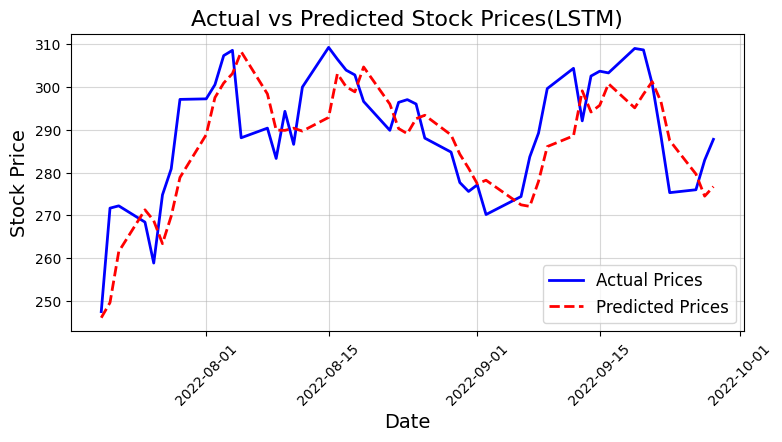

In [ ]:
import matplotlib.pyplot as plt

# Extract test dates for the x-axis
test_dates = merged_data['Date'].iloc[train_size:]

# Ensure test_dates aligns with y_test_actual and y_pred
test_dates = test_dates.reset_index(drop=True)

# Plot actual vs predicted stock prices with dates
plt.figure(figsize=(8, 4))
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted Prices', color='red', linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Stock Prices(LSTM)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()


## Random Forest Regressor

In [ ]:
# Convert 'Date' to datetime and sort by date
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data = merged_data.sort_values(by='Date')


In [ ]:
# Create lagged features for stock price
merged_data['lag_1_price'] = merged_data['stock_price'].shift(1)
merged_data['lag_2_price'] = merged_data['stock_price'].shift(2)

# Drop rows with NaN values caused by lagging
merged_data.dropna(inplace=True)

# Features (X) and Target (y)
X = merged_data[['lag_1_price', 'lag_2_price', 'daily_avg_sentiment', '14d_avg_sentiment']]
y = merged_data['stock_price']


In [ ]:
# Split the data (80% train, 20% test)
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)


In [ ]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest R² Score: {r2_rf:.2f}")


Random Forest Mean Squared Error: 119.82
Random Forest R² Score: 0.39


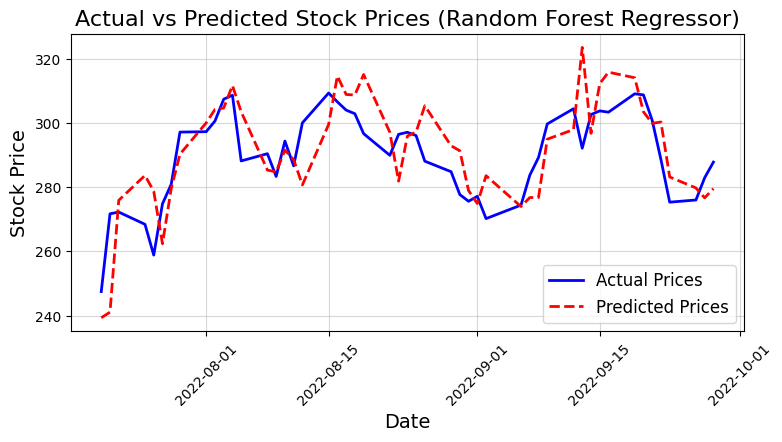

In [ ]:
import matplotlib.pyplot as plt

# Extract test dates for the x-axis
test_dates_rf = merged_data['Date'].iloc[train_size:]

# Ensure test_dates aligns with y_test and y_pred_rf
test_dates_rf = test_dates_rf.reset_index(drop=True)

# Plot actual vs predicted stock prices with dates
plt.figure(figsize=(8, 4))
plt.plot(test_dates_rf, y_test.values, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates_rf, y_pred_rf, label='Predicted Prices', color='red', linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Stock Prices (Random Forest Regressor)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()



## XGBoost Regressor

In [ ]:
# Convert 'Date' to datetime and sort by date
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data = merged_data.sort_values(by='Date')

In [ ]:
# Create lagged features for stock price
merged_data['lag_1_price'] = merged_data['stock_price'].shift(1)
merged_data['lag_2_price'] = merged_data['stock_price'].shift(2)

# Drop rows with NaN values caused by lagging
merged_data.dropna(inplace=True)

# Features (X) and Target (y)
X = merged_data[['lag_1_price', 'lag_2_price', 'daily_avg_sentiment', '14d_avg_sentiment']]
y = merged_data['stock_price']


In [ ]:
# Split the data (80% train, 20% test)
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error: {mse_xgb:.2f}")
print(f"XGBoost R² Score: {r2_xgb:.2f}")


XGBoost Mean Squared Error: 186.83
XGBoost R² Score: 0.05


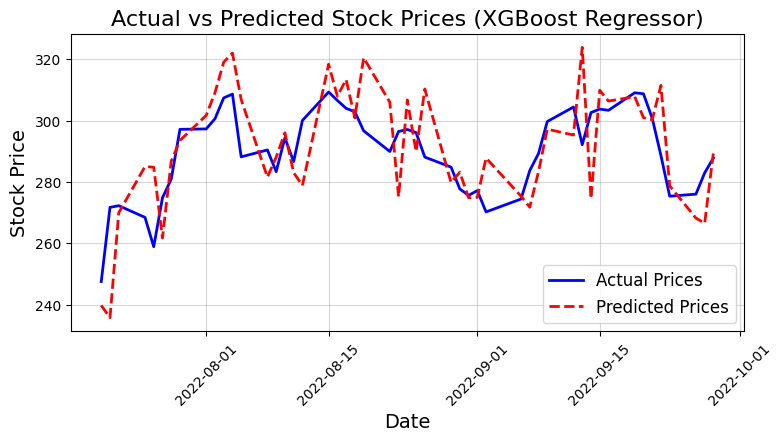

In [ ]:
import matplotlib.pyplot as plt

# Extract test dates for the x-axis
test_dates_xgb = merged_data['Date'].iloc[train_size:]

# Ensure test_dates aligns with y_test and y_pred_xgb
test_dates_xgb = test_dates_xgb.reset_index(drop=True)

# Plot actual vs predicted stock prices with dates
plt.figure(figsize=(8, 4))
plt.plot(test_dates_xgb, y_test.values, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates_xgb, y_pred_xgb, label='Predicted Prices', color='red', linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Stock Prices (XGBoost Regressor)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()


## Stacking Model with Random Forest + XGBoost

In [ ]:
!pip install --upgrade scikit-learn xgboost


In [ ]:
import sklearn
import xgboost
print(f"scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

scikit-learn version: 1.2.2
XGBoost version: 2.1.3


In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install scikit-learn==1.2.2
!pip install xgboost==1.7.3

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


  Using cached xgboost-1.7.3-py3-none-manylinux2014_x86_64.whl.metadata (1.9 kB)
Using cached xgboost-1.7.3-py3-none-manylinux2014_x86_64.whl (193.6 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


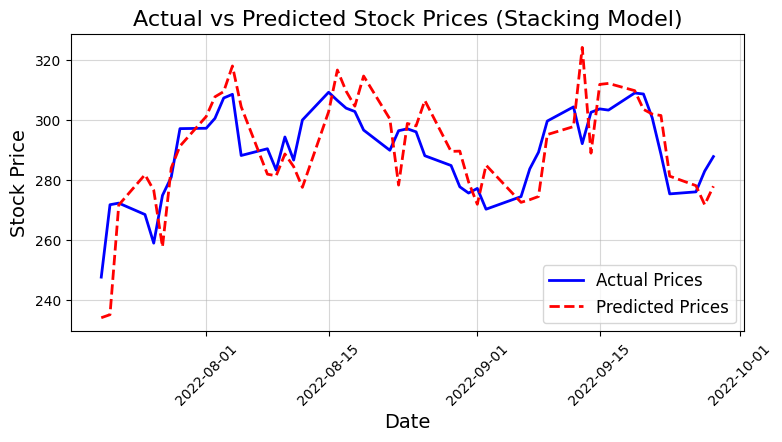

In [ ]:
import matplotlib.pyplot as plt

# Extract test dates for the x-axis
test_dates_stack = merged_data['Date'].iloc[train_size:]

# Ensure test_dates aligns with y_test and y_pred_stack
test_dates_stack = test_dates_stack.reset_index(drop=True)

# Plot actual vs predicted stock prices with dates
plt.figure(figsize=(8, 4))
plt.plot(test_dates_stack, y_test.values, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates_stack, y_pred_stack, label='Predicted Prices', color='red', linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Stock Prices (Stacking Model)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()


## Hybrid Stacking with Feature Engineering and Diverse Base Learners

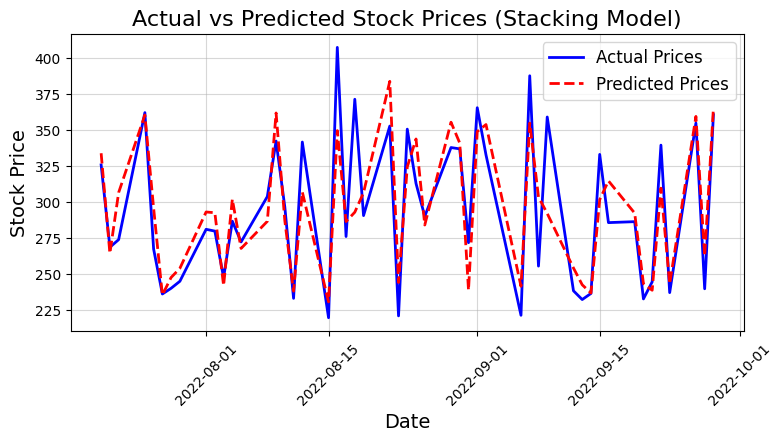

In [ ]:
import matplotlib.pyplot as plt

# Assuming that 'train_size' is defined or calculated earlier in the code
# Extract test dates from merged_data and ensure it aligns with y_test and y_pred_stack
test_dates_stack = merged_data['Date'].iloc[len(y_train):]  # Adjust index based on y_train size

# Reset index to align with y_test and y_pred_stack
test_dates_stack = test_dates_stack.reset_index(drop=True)

# Plot Actual vs Predicted stock prices with dates on the x-axis
plt.figure(figsize=(8, 4))
plt.plot(test_dates_stack, y_test.values, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates_stack, y_pred_stack, label='Predicted Prices', color='red', linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Stock Prices (Stacking Model)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()



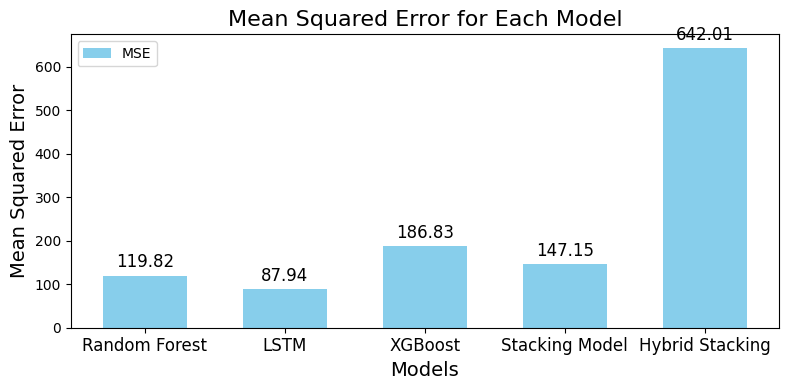

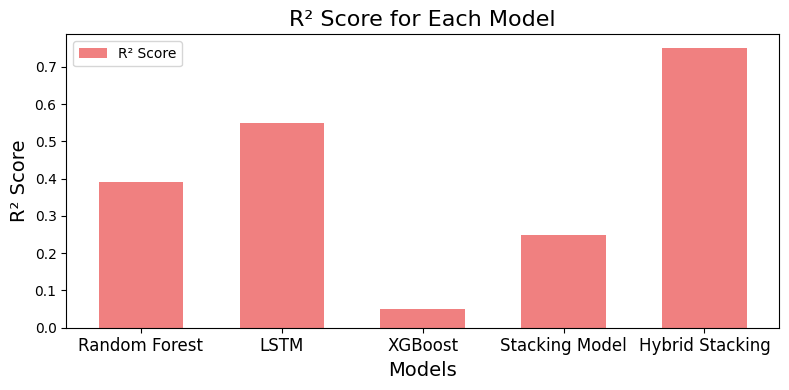

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'LSTM', 'XGBoost', 'Stacking Model', 'Hybrid Stacking']

# Mean Squared Error (MSE) values for each model
mse_values = [119.82, 87.94, 186.83, 147.15, 642.01]

# R² Score values for each model
r2_values = [0.39, 0.55, 0.05, 0.25, 0.75]

# Number of models
n_models = len(models)

# X-axis positions for the bars
x = np.arange(n_models)

# Width of the bars
width = 0.6

# Plotting MSE bar graph
fig, ax = plt.subplots(figsize=(8, 4))

rects1 = ax.bar(x, mse_values, width, label='MSE', color='skyblue')

# Add title and labels for MSE plot
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_title('Mean Squared Error for Each Model', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Add data labels to MSE bars
def add_labels(rects, values):
    for rect, value in zip(rects, values):
        height = rect.get_height()
        ax.annotate(f'{value:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

add_labels(rects1, mse_values)

plt.tight_layout()
plt.show()


# Plotting R² bar graph
fig, ax2 = plt.subplots(figsize=(8, 4))

rects2 = ax2.bar(x, r2_values, width, label='R² Score', color='lightcoral')

# Add title and labels for R² plot
ax2.set_xlabel('Models', fontsize=14)
ax2.set_ylabel('R² Score', fontsize=14)
ax2.set_title('R² Score for Each Model', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(models, fontsize=12)
ax2.legend()

# Add data labels to R² bars
add_labels(rects2, r2_values)

plt.tight_layout()
plt.show()
